In [1]:
from boruta import BorutaPy

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import os
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE,ADASYN,SMOTE,SVMSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from math import ceil
from numpy.random import RandomState

### Reading the Data

In [3]:
df = pd.read_excel("train.xlsx")
df.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [4]:
original = df.copy()

In [5]:
df.replace("?", np.nan, inplace=True)
df.isna().sum()

CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [6]:
df.isna().sum()/len(df)*100

CITIZEN_ID                0.000000
Name                      0.000000
Birthday                  0.000000
Native Continent          0.000000
Marital Status            0.000000
Lives with                0.000000
Base Area                 1.763393
Education Level           0.000000
Years of Education        0.000000
Employment Sector         5.642857
Role                      5.674107
Working Hours per week    0.000000
Money Received            0.000000
Ticket Price              0.000000
Income                    0.000000
dtype: float64

In [7]:
df[["Gender","Name"]]=df["Name"].str.split(" ", n=1,expand=True)
df.Gender.unique()

array(['Mr.', 'Miss', 'Mrs.'], dtype=object)

In [8]:
df["Gender"].replace(["Mr."],"M",inplace=True)
df["Gender"].replace(["Miss","Mrs."],"F",inplace=True)
df.Gender.unique()

array(['M', 'F'], dtype=object)

In [9]:
df[["Mouth","Year"]]=df['Birthday'].str.split(",",expand=True)
df["Year"]=df["Year"].astype(int)

In [10]:
df["Age"] = 2046 - df["Year"]
df["Age"] 

0        43
1        40
2        37
3        61
4        31
         ..
22395    23
22396    21
22397    24
22398    35
22399    20
Name: Age, Length: 22400, dtype: int32

In [11]:
df.set_index("CITIZEN_ID",inplace=True)

In [12]:
df.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

In [13]:
df.head()

,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income,Gender,Age
CITIZEN_ID,,,,,,,,,,,,,,
12486,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1,M,43
12487,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1,M,40
12488,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1,M,37
12489,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1,M,61
12490,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1,M,31


In [14]:
df.dtypes

Native Continent          object
Marital Status            object
Lives with                object
Base Area                 object
Education Level           object
Years of Education         int64
Employment Sector         object
Role                      object
Working Hours per week     int64
Money Received             int64
Ticket Price               int64
Income                     int64
Gender                    object
Age                        int32
dtype: object

In [15]:
categorical = df.select_dtypes(include="object").columns.to_list()
numerical = df.columns.drop(categorical).drop("Income").to_list()

### Visualize

In [16]:
df["Marital Status"].replace(["Married - Spouse Missing","Married - Spouse in the Army" ],"Married",inplace=True)
df["Marital Status"].replace(["Separated","Divorced" ],"Divorced",inplace=True)

In [17]:
df["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
df["Lives with"].replace(["Other relatives","Other Family" ],"Other",inplace=True)

In [18]:
base_area_values=df["Base Area"].unique().tolist()
base_area_values.remove("Northbury")
df["Base Area"]=df["Base Area"].replace(base_area_values,"Others Base Areas")

In [19]:
df["Education Level"].replace(["High School - 2nd Cycle","High School - 1st Cycle","Middle School Complete"],"Middle School",inplace=True)
df["Education Level"].replace(["Middle School - 2nd Cycle","Middle School - 1st Cycle","Primary School","Preschool","PhD"],"Other",inplace=True)

In [20]:
df["Employment Sector"].replace(["Private Sector - Services ","Private Sector - Others"],"Private Sector",inplace=True)
df["Employment Sector"].replace(["Public Sector - Others","Public Sector - Government"],"Public Sector",inplace=True)
df["Employment Sector"].replace(["Self-Employed (Individual)","Self-Employed (Company)"],"Self-Employed",inplace=True)
df["Employment Sector"].replace(["Unemployed","Never Worked"],"Other",inplace=True)

In [21]:
df["Role"].replace(["Security","Cleaners & Handlers","Machine Operators & Inspectors","Transports","Agriculture and Fishing","Household Services","Army","IT"],"Other services",inplace=True)

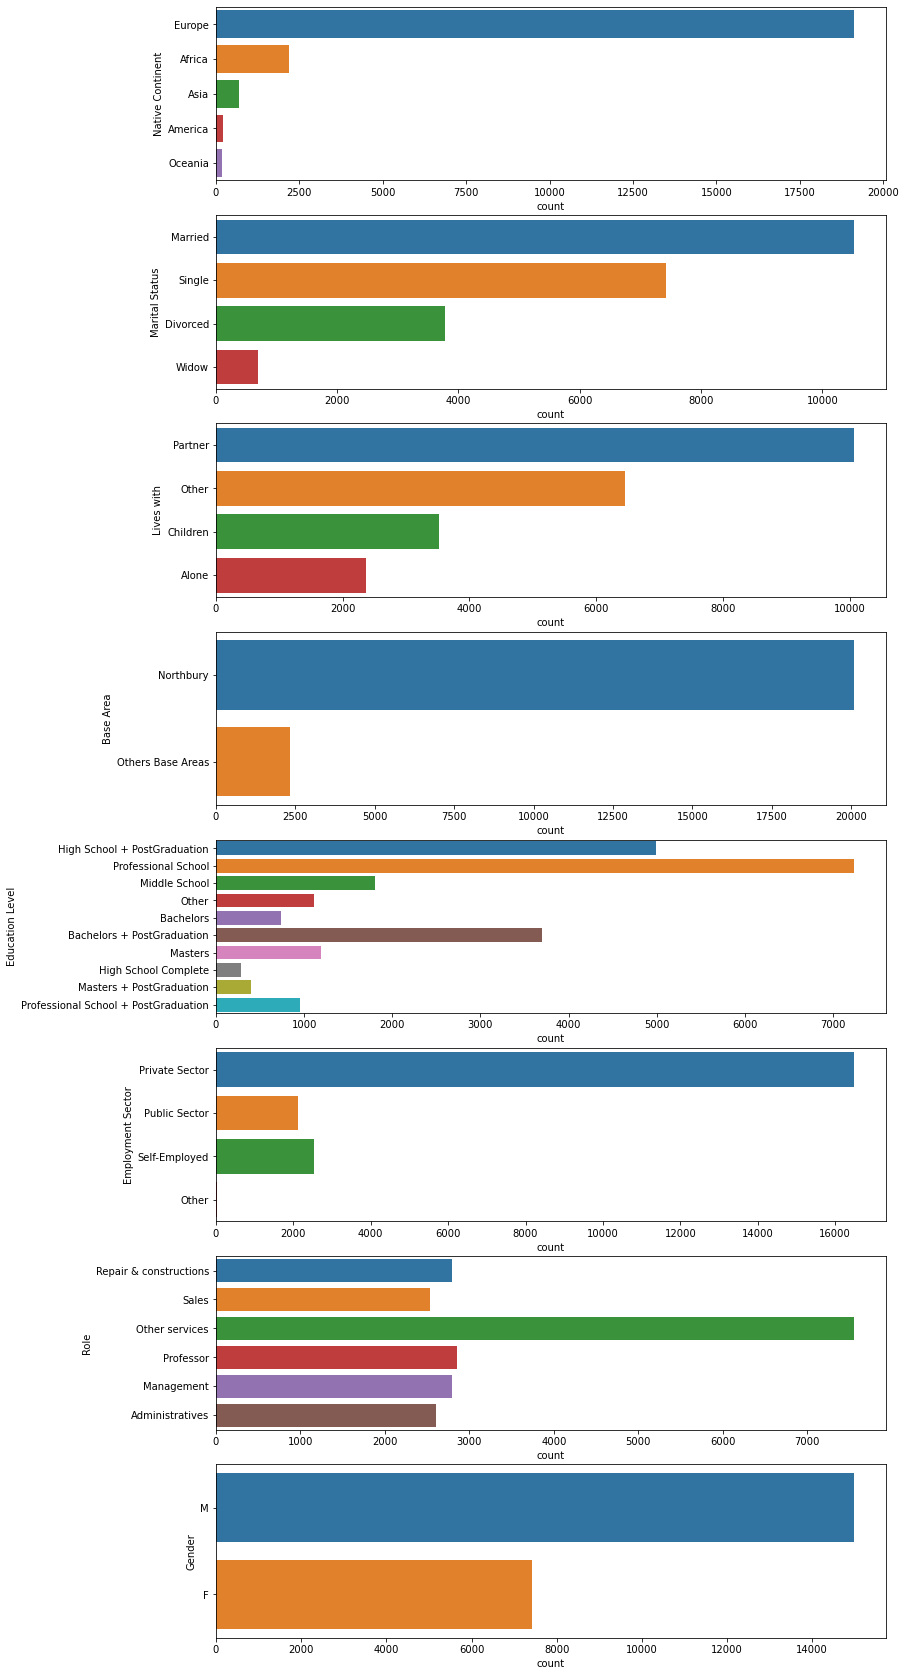

In [22]:
fig, axes = plt.subplots(len(categorical), ceil(len(categorical) / len(categorical)), figsize=(12, 30))
for ax, feat in zip(axes.flatten(), categorical):
    sns.countplot(y=df[feat], data=df, ax=ax) 
plt.show()

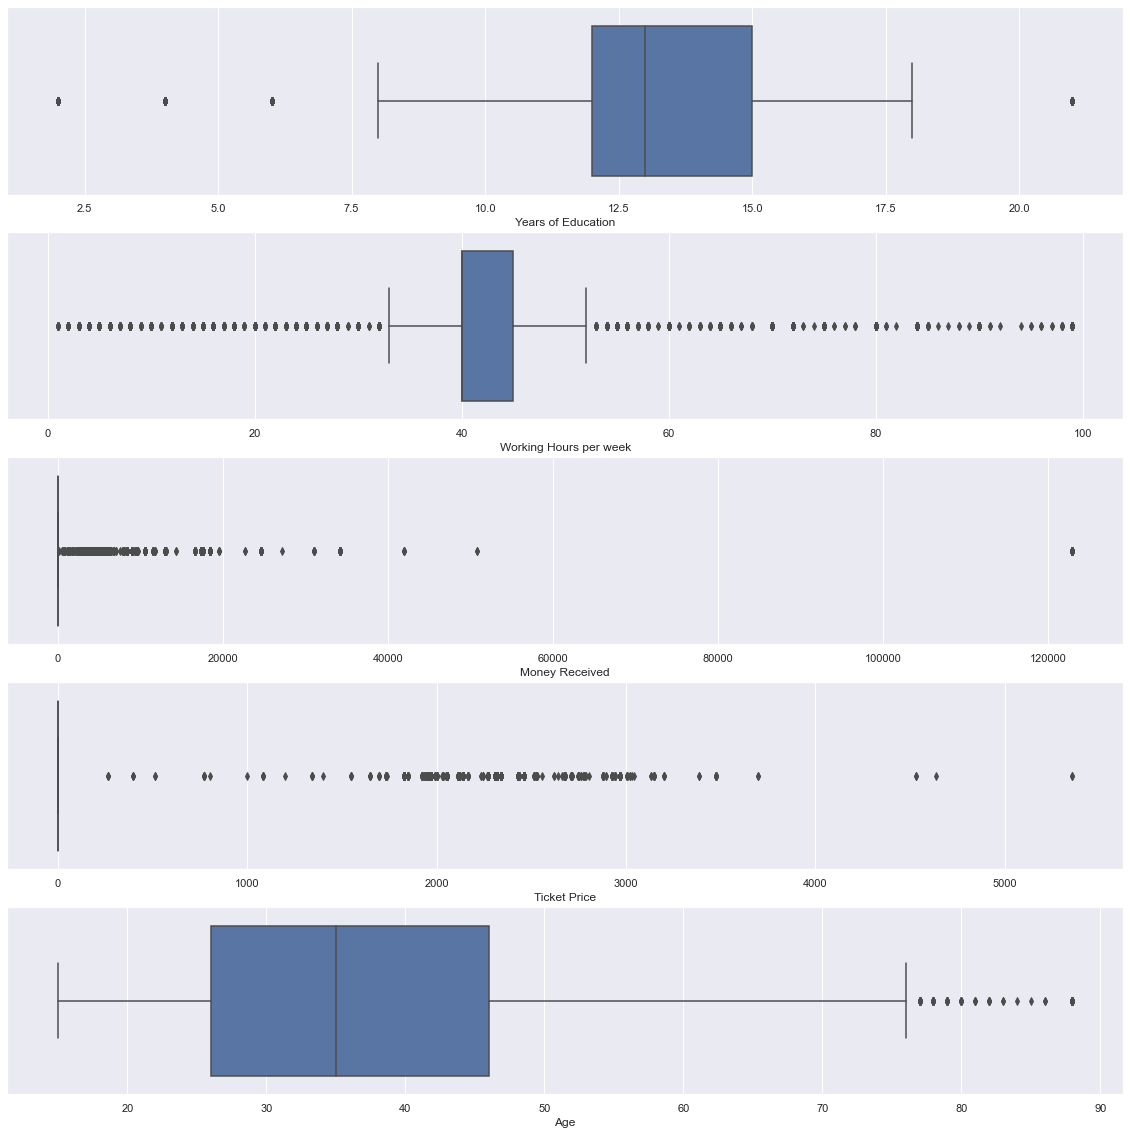

In [23]:
sns.set()
fig, axes = plt.subplots(len(numerical), ceil(len(numerical) / len(numerical)), figsize=(20, 20))
for ax, feat in zip(axes.flatten(), numerical):
    sns.boxplot(x=df[feat], ax=ax) 
plt.show()

### Fill Missing Values

In [24]:
modes = df[categorical].mode().loc[0]
df.fillna(modes,inplace=True)

In [25]:
df.isna().sum()

Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
Gender                    0
Age                       0
dtype: int64

### Removing Outliers

In [26]:
filters = (
    (df["Working Hours per week"]<=80)
    & 
    (df["Years of Education"]<20)
    &
    (df["Age"]<80))

df1=df[filters]
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / original.shape[0], 4))
df=df1.copy()

Percentage of data kept after removing outliers: 0.9784


### Separating X and Y

In [27]:
X=df.drop(["Income"],axis=1)
y=df.loc[:,"Income"]
categorical=X.select_dtypes(include="object").columns.to_list()

### Calculate the number for the weight in class

In [28]:
weight=int(round(y.value_counts()[0]/y.value_counts()[1]))

### Data Splitting

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

In [30]:
model = CatBoostClassifier(iterations=100,cat_features=categorical,eval_metric="F1",scale_pos_weight=weight,verbose=10)
model.fit(X_train, y_train,eval_set=(X_test, y_test), use_best_model=True)

Learning rate set to 0.175042
0:	learn: 0.7978993	test: 0.7887538	best: 0.7887538 (0)	total: 74.2ms	remaining: 7.35s
10:	learn: 0.8186907	test: 0.8054211	best: 0.8086201 (8)	total: 252ms	remaining: 2.04s
20:	learn: 0.8243719	test: 0.8078049	best: 0.8110211 (18)	total: 453ms	remaining: 1.7s
30:	learn: 0.8241226	test: 0.8132618	best: 0.8132618 (30)	total: 697ms	remaining: 1.55s
40:	learn: 0.8292106	test: 0.8115516	best: 0.8166315 (35)	total: 882ms	remaining: 1.27s
50:	learn: 0.8305687	test: 0.8127764	best: 0.8166315 (35)	total: 1.08s	remaining: 1.03s
60:	learn: 0.8318101	test: 0.8126744	best: 0.8166315 (35)	total: 1.24s	remaining: 793ms
70:	learn: 0.8355031	test: 0.8150832	best: 0.8166315 (35)	total: 1.42s	remaining: 579ms
80:	learn: 0.8375466	test: 0.8162527	best: 0.8166315 (35)	total: 1.59s	remaining: 374ms
90:	learn: 0.8383542	test: 0.8191227	best: 0.8191227 (89)	total: 1.77s	remaining: 175ms
99:	learn: 0.8394016	test: 0.8177340	best: 0.8192573 (91)	total: 1.93s	remaining: 0us

bestTe

In [31]:
model.get_feature_importance()

array([ 1.26149952,  3.20657347, 28.75445622,  0.69386841,  1.70489071,
       11.99335111,  2.20705008,  7.17218897,  7.82138837, 12.50972096,
        5.14609931,  2.76309399, 14.76581888])

In [32]:
features =list(X.columns)
features

['Native Continent',
 'Marital Status',
 'Lives with',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Gender',
 'Age']

In [33]:
feat_import = [t for t in zip(features, model.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending=False)
feat_import_df

,Feature,VarImp
2,Lives with,28.754456
12,Age,14.765819
9,Money Received,12.509721
5,Years of Education,11.993351
8,Working Hours per week,7.821388
7,Role,7.172189
10,Ticket Price,5.146099
1,Marital Status,3.206573
11,Gender,2.763094
6,Employment Sector,2.207050


### Feature Selection

In [34]:
X.drop(["Education Level","Base Area","Employment Sector","Native Continent"],axis=1,inplace=True)
categorical=X.select_dtypes(include="object").columns.to_list()

### One Hot Encoder

In [35]:
df_ohc = X.copy()

In [36]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
df_ohc

,Marital Status_Married,Marital Status_Single,Marital Status_Widow,Lives with_Children,Lives with_Other,Lives with_Partner,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Gender_M,Years of Education,Working Hours per week,Money Received,Ticket Price,Age
CITIZEN_ID,,,,,,,,,,,,,,,,,
12486,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,13,40,0,2273,43
12487,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,12,40,0,0,40
12488,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12,46,0,2321,37
12489,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,11,37,5395,0,61
12491,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,15,30,0,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34880,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,16,45,0,0,33
34881,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12,40,0,0,23
34882,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,12,35,0,0,21


In [37]:
X=df_ohc.copy()
X.head()

,Marital Status_Married,Marital Status_Single,Marital Status_Widow,Lives with_Children,Lives with_Other,Lives with_Partner,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Gender_M,Years of Education,Working Hours per week,Money Received,Ticket Price,Age
CITIZEN_ID,,,,,,,,,,,,,,,,,
12486,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,13,40,0,2273,43
12487,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,12,40,0,0,40
12488,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12,46,0,2321,37
12489,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,11,37,5395,0,61
12491,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,15,30,0,0,22


### Data Splitting

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1,stratify=y, shuffle = True) 

### SMOTE

In [169]:
#oversampling=SVMSMOTE()
#X_train, y_train = oversampling.fit_resample(X_train, y_train)

In [124]:
#X_test, y_test = oversampling.fit_resample(X_test, y_test)

### Standard Scaler

In [183]:
scaler_X_train = MinMaxScaler().fit(X_train).transform(X_train)
scaler_X_test = MinMaxScaler().fit(X_test).transform(X_test)

### Random Forest

In [244]:
model = RandomForestClassifier(n_estimators=1000,criterion="entropy",random_state=20,max_depth=16,n_jobs=-1,min_samples_leaf=8,max_features=15,class_weight={1:2})
#model=BalancedRandomForestClassifier(n_estimators=1000,criterion="entropy",random_state=20,max_depth=18,n_jobs=-1,min_samples_leaf=8,max_features=15)
model.fit(scaler_X_train, y_train)

RandomForestClassifier(class_weight={1: 2}, criterion='entropy', max_depth=16,
                       max_features=15, min_samples_leaf=8, n_estimators=1000,
                       n_jobs=-1, random_state=20)

In [245]:
y_pred=model.predict(scaler_X_test)
f1_score(y_pred,y_test)

0.7038231229847995

In [236]:
accuracy_score(y_pred,y_test)

0.8533302919708029

In [215]:
dataframe=pd.DataFrame()
dataframe["Income"]=y_pred

In [216]:
dataframe

,Income
0,1
1,1
2,0
3,0
4,0
...,...
4379,0
4380,1
4381,0
4382,0


In [228]:
dataframe[dataframe.Income==1]

,Income
0,1
1,1
5,1
6,1
8,1
...,...
4359,1
4362,1
4371,1
4378,1


In [46]:
y_test

CITIZEN_ID
31354    0
21347    1
25190    0
20425    0
25888    0
        ..
30318    0
25088    1
28897    0
22220    0
22549    0
Name: Income, Length: 4384, dtype: int64

### Cross-Validation

In [47]:
cv_results = cross_validate(model, scaler_X_train,y_train, cv=10, scoring=["f1"])

In [48]:
cv_results["test_f1"].mean()

0.636100186051965

# Export

In [49]:
test = pd.read_excel("test.xlsx")
original=test.copy()

test[["Gender","Name"]]=test["Name"].str.split(" ", n=1,expand=True)
test["Gender"].replace(["Mr."],"M",inplace=True)
test["Gender"].replace(["Miss","Mrs."],"F",inplace=True)
test[["Mouth","Year"]]=test['Birthday'].str.split(",",expand=True)
test["Year"]=test["Year"].astype(int)

test["Age"] = 2046 - test["Year"]
test["Age"] 
test.set_index("CITIZEN_ID",inplace=True)
test.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

test["Marital Status"].replace(["Married - Spouse Missing","Married - Spouse in the Army" ],"Married",inplace=True)
test["Marital Status"].replace(["Separated","Divorced" ],"Divorced",inplace=True)
test["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
test["Lives with"].replace(["Other relatives","Other Family" ],"Other",inplace=True)
test["Role"].replace(["Security","Cleaners & Handlers","Machine Operators & Inspectors","Transports","Agriculture and Fishing","Household Services","Army","IT"],"Other services",inplace=True)

test.drop(["Education Level","Base Area","Employment Sector","Native Continent"],axis=1,inplace=True)
categorical=test.select_dtypes(include="object").columns.to_list()

df_ohc = test.copy()
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index,columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
test=df_ohc.copy()

scaler=StandardScaler().fit(test).transform(test)
test.drop("Role_Administratives",axis=1,inplace=True)
predict=model.predict(test)
print(predict)
# final dataframe

dataframe=pd.DataFrame()

dataframe["CITIZEN_ID"]=original["CITIZEN_ID"]
dataframe["Income"]= predict

dataframe.to_csv("Predictions")

[1 0 1 ... 0 0 0]


In [50]:
dataframe[dataframe["Income"]==0]


,CITIZEN_ID,Income
1,34887,0
5,34891,0
7,34893,0
8,34894,0
9,34895,0
...,...,...
10090,44976,0
10093,44979,0
10097,44983,0
10098,44984,0
